# Thrones2Vec

Adapted from Thrones2Vect by Yuriy Guts, 2016

Apply negative sampling to explore semantic properties (e.g. distances or "neighborhoods") of words from any given text.

see 2nd response: https://www.quora.com/How-does-word2vec-work-Can-someone-walk-through-a-specific-example

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [8]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [9]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/jonathansherman/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jonathansherman/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Prepare Corpus

**Load books from files**

In [19]:
book_filenames = sorted(glob.glob("data/*.txt"))

In [20]:
print("Found books:")
book_filenames

Found books:


['data/got1.txt',
 'data/got2.txt',
 'data/got3.txt',
 'data/got4.txt',
 'data/got5.txt']

**Combine the books into one string**

In [21]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data/got1.txt'...
Corpus is now 1770659 characters long

Reading 'data/got2.txt'...
Corpus is now 4071041 characters long

Reading 'data/got3.txt'...
Corpus is now 6391405 characters long

Reading 'data/got4.txt'...
Corpus is now 8107945 characters long

Reading 'data/got5.txt'...
Corpus is now 9719485 characters long



**Split the corpus into sentences**

In [22]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [23]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [24]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [25]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [26]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [27]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


## Train Word2Vec

In [28]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [29]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [30]:
thrones2vec.build_vocab(sentences)

2018-07-03 12:27:23,608 : INFO : collecting all words and their counts
2018-07-03 12:27:23,609 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-07-03 12:27:23,648 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2018-07-03 12:27:23,684 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2018-07-03 12:27:23,716 : INFO : PROGRESS: at sentence #30000, processed 420336 words, keeping 16598 word types
2018-07-03 12:27:23,751 : INFO : PROGRESS: at sentence #40000, processed 556581 words, keeping 18324 word types
2018-07-03 12:27:23,783 : INFO : PROGRESS: at sentence #50000, processed 686247 words, keeping 19714 word types
2018-07-03 12:27:23,822 : INFO : PROGRESS: at sentence #60000, processed 828497 words, keeping 21672 word types
2018-07-03 12:27:23,860 : INFO : PROGRESS: at sentence #70000, processed 973830 words, keeping 23093 word types
2018-07-03 12:27:23,896 : INFO : PROGRESS: at 

In [36]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 17277


**Start training, this might take a minute or two...**

In [40]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=100)

2018-07-03 12:32:34,493 : INFO : training model with 8 workers on 17277 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2018-07-03 12:32:35,523 : INFO : EPOCH 1 - PROGRESS: at 25.93% examples, 357169 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:32:36,539 : INFO : EPOCH 1 - PROGRESS: at 55.13% examples, 376424 words/s, in_qsize 16, out_qsize 1
2018-07-03 12:32:37,544 : INFO : EPOCH 1 - PROGRESS: at 85.61% examples, 389182 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:32:37,996 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:32:38,000 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:32:38,002 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:32:38,021 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:32:38,024 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:32:38,042 : INFO : worker thread finish

2018-07-03 12:33:02,704 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:33:02,722 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:33:02,731 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:33:02,734 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:33:02,751 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:33:02,793 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:33:02,794 : INFO : EPOCH - 7 : training on 1818103 raw words (1405252 effective words) took 4.1s, 342845 effective words/s
2018-07-03 12:33:03,846 : INFO : EPOCH 8 - PROGRESS: at 22.68% examples, 304599 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:33:04,858 : INFO : EPOCH 8 - PROGRESS: at 49.84% examples, 335194 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:33:05,886 : INFO : EPOCH 8 - PROGRESS: at 75.10% examples, 338659 words/s, 

2018-07-03 12:33:28,461 : INFO : EPOCH 14 - PROGRESS: at 22.68% examples, 298726 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:33:29,470 : INFO : EPOCH 14 - PROGRESS: at 48.23% examples, 320937 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:33:30,496 : INFO : EPOCH 14 - PROGRESS: at 70.93% examples, 319531 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:33:31,512 : INFO : EPOCH 14 - PROGRESS: at 95.00% examples, 322888 words/s, in_qsize 11, out_qsize 0
2018-07-03 12:33:31,626 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:33:31,628 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:33:31,634 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:33:31,662 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:33:31,663 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:33:31,671 : INFO : worker thread finished; awaiting finish of 2 more th

2018-07-03 12:33:57,010 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:33:57,027 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:33:57,035 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:33:57,045 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:33:57,058 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:33:57,069 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:33:57,081 : INFO : EPOCH 20 - PROGRESS: at 99.56% examples, 340094 words/s, in_qsize 1, out_qsize 1
2018-07-03 12:33:57,082 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:33:57,115 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:33:57,117 : INFO : EPOCH - 20 : training on 1818103 raw words (1404258 effective words) took 4.1s, 339024 effective words/s
2018-07-03 12:33:58,

2018-07-03 12:34:23,433 : INFO : EPOCH 26 - PROGRESS: at 98.00% examples, 339870 words/s, in_qsize 4, out_qsize 1
2018-07-03 12:34:23,435 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:34:23,437 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:34:23,444 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:34:23,459 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:34:23,480 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:34:23,481 : INFO : EPOCH - 26 : training on 1818103 raw words (1404192 effective words) took 4.1s, 343437 effective words/s
2018-07-03 12:34:24,529 : INFO : EPOCH 27 - PROGRESS: at 23.22% examples, 312968 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:34:25,530 : INFO : EPOCH 27 - PROGRESS: at 49.84% examples, 337625 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:34:26,581 : INFO : EPOCH 27 - PROGRESS: at 70.36%

2018-07-03 12:34:49,301 : INFO : EPOCH 33 - PROGRESS: at 23.24% examples, 319618 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:34:50,330 : INFO : EPOCH 33 - PROGRESS: at 50.87% examples, 344069 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:34:51,346 : INFO : EPOCH 33 - PROGRESS: at 77.28% examples, 350950 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:34:52,130 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:34:52,143 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:34:52,145 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:34:52,164 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:34:52,172 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:34:52,185 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:34:52,196 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:34:5

2018-07-03 12:35:16,945 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:35:16,954 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:35:16,963 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:35:16,972 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:35:16,994 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:35:16,995 : INFO : EPOCH - 39 : training on 1818103 raw words (1405098 effective words) took 4.0s, 346972 effective words/s
2018-07-03 12:35:18,081 : INFO : EPOCH 40 - PROGRESS: at 23.22% examples, 302182 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:35:19,111 : INFO : EPOCH 40 - PROGRESS: at 50.87% examples, 334390 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:35:20,116 : INFO : EPOCH 40 - PROGRESS: at 75.70% examples, 338012 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:35:21,051 : INFO : worker thread finished; await

2018-07-03 12:35:43,585 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:35:43,596 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:35:43,630 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:35:43,631 : INFO : EPOCH - 45 : training on 1818103 raw words (1404495 effective words) took 5.2s, 271964 effective words/s
2018-07-03 12:35:44,710 : INFO : EPOCH 46 - PROGRESS: at 18.75% examples, 251879 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:35:45,720 : INFO : EPOCH 46 - PROGRESS: at 44.46% examples, 297406 words/s, in_qsize 14, out_qsize 1
2018-07-03 12:35:46,749 : INFO : EPOCH 46 - PROGRESS: at 66.04% examples, 298649 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:35:47,762 : INFO : EPOCH 46 - PROGRESS: at 88.47% examples, 299893 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:35:48,110 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:35:48,113 : INFO : worke

2018-07-03 12:36:09,373 : INFO : EPOCH - 51 : training on 1818103 raw words (1404534 effective words) took 4.2s, 333187 effective words/s
2018-07-03 12:36:10,405 : INFO : EPOCH 52 - PROGRESS: at 18.83% examples, 257109 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:36:11,475 : INFO : EPOCH 52 - PROGRESS: at 45.49% examples, 299383 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:36:12,483 : INFO : EPOCH 52 - PROGRESS: at 70.36% examples, 316619 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:36:13,539 : INFO : EPOCH 52 - PROGRESS: at 92.44% examples, 310240 words/s, in_qsize 14, out_qsize 1
2018-07-03 12:36:13,756 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:36:13,768 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:36:13,783 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:36:13,787 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:36:13,797 : INFO : worke

2018-07-03 12:36:38,448 : INFO : EPOCH 58 - PROGRESS: at 42.68% examples, 286209 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:36:39,505 : INFO : EPOCH 58 - PROGRESS: at 66.04% examples, 298461 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:36:40,523 : INFO : EPOCH 58 - PROGRESS: at 87.41% examples, 295639 words/s, in_qsize 15, out_qsize 1
2018-07-03 12:36:41,035 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:36:41,048 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:36:41,050 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:36:41,067 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:36:41,080 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:36:41,088 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:36:41,135 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:36:4

2018-07-03 12:37:06,045 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:37:06,060 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:37:06,078 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:37:06,116 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:37:06,118 : INFO : EPOCH - 64 : training on 1818103 raw words (1403980 effective words) took 4.6s, 307531 effective words/s
2018-07-03 12:37:07,152 : INFO : EPOCH 65 - PROGRESS: at 18.24% examples, 249140 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:37:08,185 : INFO : EPOCH 65 - PROGRESS: at 43.68% examples, 289559 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:37:09,190 : INFO : EPOCH 65 - PROGRESS: at 65.00% examples, 295629 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:37:10,266 : INFO : EPOCH 65 - PROGRESS: at 88.47% examples, 296795 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:37:10,620 : INFO : worke

2018-07-03 12:37:34,062 : INFO : EPOCH 71 - PROGRESS: at 70.93% examples, 322674 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:37:35,075 : INFO : EPOCH 71 - PROGRESS: at 96.49% examples, 331313 words/s, in_qsize 7, out_qsize 1
2018-07-03 12:37:35,077 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:37:35,080 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:37:35,105 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:37:35,119 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:37:35,120 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:37:35,131 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:37:35,133 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:37:35,157 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:37:35,158 : INFO : EPOCH - 71

2018-07-03 12:37:59,367 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:37:59,369 : INFO : EPOCH - 77 : training on 1818103 raw words (1405231 effective words) took 4.0s, 351322 effective words/s
2018-07-03 12:38:00,396 : INFO : EPOCH 78 - PROGRESS: at 22.68% examples, 311946 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:38:01,402 : INFO : EPOCH 78 - PROGRESS: at 49.29% examples, 336545 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:38:02,451 : INFO : EPOCH 78 - PROGRESS: at 75.70% examples, 342337 words/s, in_qsize 16, out_qsize 1
2018-07-03 12:38:03,279 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:38:03,286 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:38:03,305 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:38:03,307 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:38:03,312 : INFO : worker thread finished; await

2018-07-03 12:38:27,783 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:38:27,785 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:38:27,809 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:38:27,825 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:38:27,835 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:38:27,836 : INFO : EPOCH - 84 : training on 1818103 raw words (1404130 effective words) took 4.0s, 350045 effective words/s
2018-07-03 12:38:28,873 : INFO : EPOCH 85 - PROGRESS: at 22.68% examples, 309283 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:38:29,898 : INFO : EPOCH 85 - PROGRESS: at 49.84% examples, 335721 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:38:30,901 : INFO : EPOCH 85 - PROGRESS: at 75.70% examples, 344416 words/s, in_qsize 14, out_qsize 1
2018-07-03 12:38:31,752 : INFO : worker thread finished; await

2018-07-03 12:38:55,421 : INFO : EPOCH 91 - PROGRESS: at 75.10% examples, 336836 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:38:56,387 : INFO : worker thread finished; awaiting finish of 7 more threads
2018-07-03 12:38:56,392 : INFO : worker thread finished; awaiting finish of 6 more threads
2018-07-03 12:38:56,402 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-07-03 12:38:56,411 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:38:56,418 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:38:56,434 : INFO : EPOCH 91 - PROGRESS: at 99.04% examples, 338150 words/s, in_qsize 2, out_qsize 1
2018-07-03 12:38:56,435 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:38:56,444 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:38:56,460 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:38:56,461 : INFO : EPOCH - 91

2018-07-03 12:39:21,573 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-07-03 12:39:21,579 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-07-03 12:39:21,587 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-07-03 12:39:21,610 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-07-03 12:39:21,629 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-07-03 12:39:21,630 : INFO : EPOCH - 97 : training on 1818103 raw words (1404434 effective words) took 4.0s, 350661 effective words/s
2018-07-03 12:39:22,713 : INFO : EPOCH 98 - PROGRESS: at 22.68% examples, 295757 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:39:23,724 : INFO : EPOCH 98 - PROGRESS: at 50.38% examples, 334011 words/s, in_qsize 15, out_qsize 0
2018-07-03 12:39:24,738 : INFO : EPOCH 98 - PROGRESS: at 76.78% examples, 344189 words/s, in_qsize 16, out_qsize 0
2018-07-03 12:39:25,562 : INFO : worker thread finished; await

(140444764, 181810300)

**Save to file, can be useful later**

In [41]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [42]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2018-07-03 12:40:53,725 : INFO : saving Word2Vec object under trained/thrones2vec.w2v, separately None
2018-07-03 12:40:53,727 : INFO : not storing attribute vectors_norm
2018-07-03 12:40:53,728 : INFO : not storing attribute cum_table
2018-07-03 12:40:54,287 : INFO : saved trained/thrones2vec.w2v


## Explore the trained model.

In [25]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

All occurrences of a word and its trained embeddings

In [52]:
print(thrones2vec.wv['hot'].shape, thrones2vec.wv['hot'])

(300,) [-3.75707984e-01  1.37408674e-02 -3.74197453e-01 -4.97455686e-01
  1.59484055e-02 -1.01808704e-01 -1.16183959e-01 -3.19191128e-01
 -3.57119441e-02  3.32097828e-01  2.78427247e-02 -1.62278816e-01
  5.03338635e-01 -1.61286406e-02  2.67632008e-01  4.27884877e-01
  1.41375482e-01 -1.02879100e-01  9.86461714e-02  4.21523601e-01
  1.11479610e-01  1.65842056e-01  8.27299774e-01  7.20206559e-01
 -3.28323990e-01  4.96960402e-01 -2.88097352e-01 -6.55851066e-01
  2.54881203e-01  1.48707718e-01 -2.12549478e-01 -2.79709429e-01
  1.68265790e-01  1.45083770e-01  9.76131707e-02 -9.29514319e-02
  1.84372395e-01  2.16129005e-01 -3.83138686e-01 -3.16444486e-01
  9.24256593e-02 -2.68346846e-01 -3.52866858e-01 -3.99936140e-02
 -2.01792374e-01 -3.91805321e-01  5.88380098e-01 -5.62631935e-02
  1.07065022e-01  4.34718341e-01  2.55952567e-01 -1.28635630e-01
 -1.15711920e-01  2.29740217e-01 -3.76424827e-02  4.95777167e-02
 -3.84780228e-01  3.64790767e-01 -1.09836511e-01 -2.91292757e-01
 -5.32472789e-01 -

### Compress the word vectors into 2D space and plot them

In [7]:
# how to visualize a high-dimensional dataset easily - can also try MDS (multidimensional scaling)
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [8]:
all_word_vectors_matrix = thrones2vec.wv.syn0

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


**Train t-SNE, this could take a minute or two...**

In [9]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [58]:
print(all_word_vectors_matrix_2d.shape, all_word_vectors_matrix.shape)

(17277, 2) (17277, 300)


In [14]:
print(all_word_vectors_matrix_2d[1,0])

3.4782712


In [73]:
vecs = pd.DataFrame(
    [
        (word, coords[:])
        for word, coords in [
            (word, all_word_vectors_matrix[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
)

In [81]:
vecs.head(10)

,0,1
0,greys,"[0.103095494, -0.43682748, 0.0332813, 0.115387..."
1,paths,"[0.65999836, 0.32669625, -0.81899804, 0.287267..."
2,stonecarver,"[0.2614176, -0.06754109, 0.17750023, 0.3094466..."
3,wretches,"[0.14822313, 0.15577061, 0.22190784, -0.053942..."
4,bony,"[0.16058023, 0.5655576, -0.2699457, -0.0998044..."
5,crust,"[0.21349826, 0.5725116, -0.5357733, 0.20484343..."
6,hesitant,"[0.3284299, -0.48351905, -0.1314966, -0.253231..."
7,village,"[0.57280594, -0.02900286, -0.3464258, -0.01550..."
8,Savages,"[0.15734456, 0.042264495, -0.37562436, -0.2554..."
9,DORMUND,"[-0.08894026, -0.047835205, -0.5246589, -0.074..."


**Plot the big picture in 2D**

In [64]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [77]:
points.head(10)

,word,x,y
0,greys,9.901370,14.075167
1,paths,1.155150,7.718918
2,stonecarver,3.641173,-10.880211
3,wretches,3.245380,-16.132408
4,bony,5.339248,1.962271
5,crust,15.054624,10.539905
6,hesitant,11.333805,-8.563855
7,village,-2.796095,5.937629
8,Savages,6.053461,-8.528894
9,DORMUND,-19.430901,9.808219


In [21]:
sns.set_context("poster")

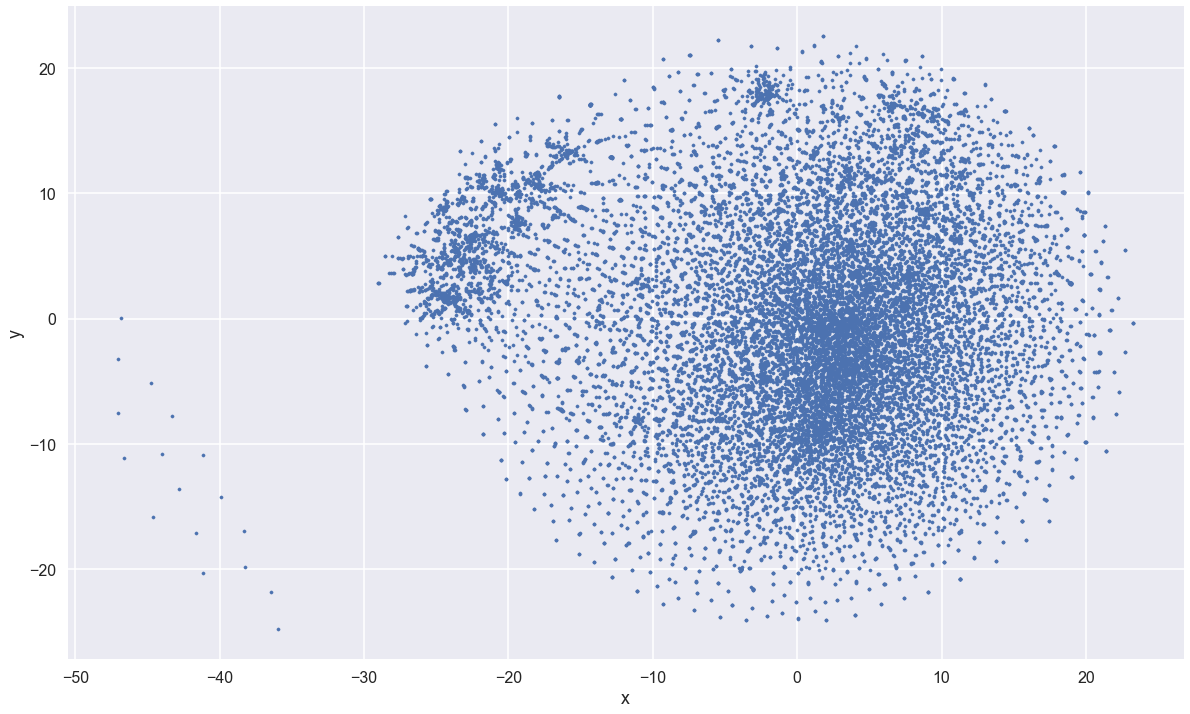

In [47]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [33]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**What similarities can we infer?**

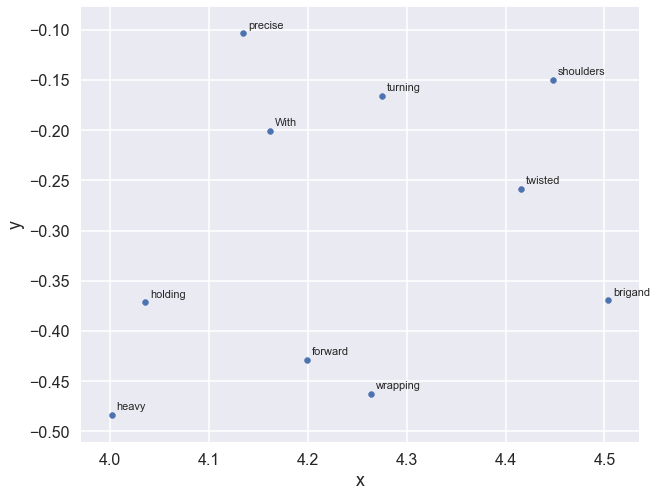

In [37]:
plot_region(x_bounds=(4.0, 4.6), y_bounds=(-0.5, -0.1))

**how about here?**

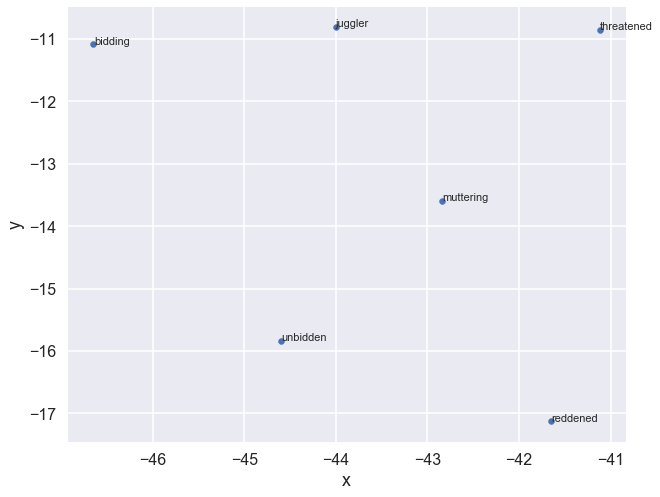

In [48]:
plot_region(x_bounds=(-50, -40), y_bounds=(-20, -10))

### Explore semantic similarities between terms with word2vec methods

Built-in word2vec tools giving us relationships

**Words closest to the given word** using cosine similarity: https://cmry.github.io/notes/euclidean-v-cosine

In [26]:
thrones2vec.most_similar("Stark")

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('Eddard', 0.6682581901550293),
 ('Jammos', 0.41915324330329895),
 ('SHIREI', 0.4170340597629547),
 ('Snowbeard', 0.41645750403404236),
 ('Edrick', 0.41144615411758423),
 ('Winterfell', 0.4093170166015625),
 ('Catelyn', 0.4029504060745239),
 ('GEREMY', 0.39984220266342163),
 ('Ned', 0.39914098381996155),
 ('divulge', 0.3936845064163208)]

In [27]:
thrones2vec.most_similar("Aerys")

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('II', 0.5130102634429932),
 ('Targaryen', 0.4554968476295471),
 ('Mad', 0.36286187171936035),
 ('Defiance', 0.3625432252883911),
 ('V', 0.36180204153060913),
 ('Robert', 0.35989105701446533),
 ('King', 0.3453548550605774),
 ('Jaehaerys', 0.3389362394809723),
 ('Darklyn', 0.33625927567481995),
 ('Mern', 0.3299587368965149)]

In [28]:
thrones2vec.most_similar("direwolf")

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


[('SHAGGYDOG', 0.44139859080314636),
 ('WIND', 0.4345802664756775),
 ('GHOST', 0.4296010136604309),
 ('wolf', 0.41804012656211853),
 ('Ghost', 0.41038668155670166),
 ('EDDISON', 0.4002611041069031),
 ('TOLLETT', 0.39542457461357117),
 ('RICKON', 0.3894764482975006),
 ('SUMMER', 0.3852330148220062),
 ('DOLOROUS', 0.3847087025642395)]

Similarity (cosine) between any two terms

In [29]:
print(thrones2vec.similarity("man", "woman"), thrones2vec.similarity("man", "dog"))

0.35427665895187843 0.2036945490299512


/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  if __name__ == '__main__':


**Linear relationships between word pairs**

In [30]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [31]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as Tully is related to Riverrun
Jaime is related to sword, as cup is related to wine
Arya is related to Nymeria, as Dany is related to dragons


/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: DeprecationWarning: Call to deprecated `most_similar_cosmul` (Method will be removed in 4.0.0, use self.wv.most_similar_cosmul() instead).


'Dany'

In [53]:
thrones2vec.wv['hot'] - thrones2vec.wv['cold']

array([-2.41345033e-01, -1.26333058e-01,  4.06956673e-02, -5.02182841e-01,
       -5.41987047e-02, -1.48776904e-01, -2.15162247e-01, -1.02240026e-01,
        3.01669121e-01,  3.73570681e-01, -8.44143480e-02, -2.43610054e-01,
        2.87757814e-02, -2.73781627e-01,  2.45911747e-01,  2.43551582e-01,
        1.52713552e-01, -2.96399057e-01,  2.45142490e-01,  1.80406183e-01,
        3.76937762e-02,  3.24454695e-01,  7.57028818e-01,  7.31668055e-01,
       -2.15624198e-01,  5.92507362e-01, -5.98697126e-01, -4.40806895e-01,
       -1.63621008e-02,  2.14455724e-02, -4.26649302e-02, -2.84551382e-02,
        3.26260269e-01, -5.25228083e-02, -1.17417008e-01,  1.27600864e-01,
       -8.70530605e-02,  3.44733179e-01, -3.98595214e-01, -2.27279529e-01,
       -1.12947792e-01,  2.09746748e-01, -1.84005335e-01, -3.41178387e-01,
       -2.06680357e-01, -3.64387929e-02,  6.36746824e-01, -1.01735398e-01,
        3.29878330e-01,  1.92548916e-01,  5.58947921e-02, -7.47022033e-02,
       -2.03823656e-01,  

In [57]:
thrones2vec.most_similar(thrones2vec.wv['hot'] - thrones2vec.wv['cold'])

/Users/jonathansherman/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  if __name__ == '__main__':


TypeError: 'numpy.float32' object is not iterable